In [2]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import vanilla_autoencoder

In [3]:
%load_ext tensorboard
!rm -rf ../workfiles/logs/


In [7]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session
sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"],
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n_genes = data_handler.generate_dataset(feature_selection_threshold = 2, 
                                                   #feature_selection_proceedure = "LASSO", 
                                                   retain_phases="Both", 
                                                   return_filenames= True,
                                                   sgdc_params = sgdc_params,
                                                   subsample = 500,
                                                   #class_balancing = "match_smaller_sample")
                                                   class_balancing = "balanced")


retained phase 2
loading samples...
loaded 2787 samples
selecting genes based on median absolute deviation threshold:  2 ...
number of genes selected :  14883


In [ ]:
#x_train, filenames = data_handler.generate_dataset(feature_selection_threshold = 5, retain_phases="2", return_filenames= True, batch_size = 128)

sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"], # LASSO selection
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n_genes = data_handler.generate_dataset(feature_selection_threshold = None, 
                                                   feature_selection_proceedure = "LASSO", 
                                                   retain_phases="2", 
                                                   return_filenames= True,
                                                   sgdc_params = sgdc_params)

best estimator: SGDClassifier(alpha=0.2, loss='log', penalty='l1')


In [8]:
latent_dim = 64

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [10]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=15, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=30)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [ ]:
%tensorboard --logdir ../workfiles/logs/fit


In [11]:
hist = autoencoder.fit(x_train, epochs=2000, callbacks=cb)

Epoch 1/2000


2023-07-26 13:57:09.426360: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


44/44 [==============================] - 9s 167ms/step - loss: 471722.0722 - lr: 0.0010
Epoch 2/2000
44/44 [==============================] - 7s 150ms/step - loss: 47072.5205 - lr: 0.0010
Epoch 3/2000
44/44 [==============================] - 7s 163ms/step - loss: 28089.1056 - lr: 0.0010
Epoch 4/2000
44/44 [==============================] - 7s 159ms/step - loss: 23459.8703 - lr: 0.0010
Epoch 5/2000
44/44 [==============================] - 7s 149ms/step - loss: 22690.6671 - lr: 0.0010
Epoch 6/2000
44/44 [==============================] - 7s 155ms/step - loss: 18453.8452 - lr: 0.0010
Epoch 7/2000
44/44 [==============================] - 6s 146ms/step - loss: 14733.1308 - lr: 0.0010
Epoch 8/2000
44/44 [==============================] - 7s 158ms/step - loss: 10468.6700 - lr: 0.0010
Epoch 9/2000
44/44 [==============================] - 7s 154ms/step - loss: 9341.2385 - lr: 0.0010
Epoch 10/2000
44/44 [==============================] - 7s 159ms/step - loss: 10192.2399 - lr: 0.0010
Epoch 11/200

In [12]:
autoencoder.load_weights(checkpoint_filepath)


[276934.09375, 42162.9140625, 25016.88671875, 23780.716796875, 20976.5546875, 17240.65234375, 13177.4482421875, 10070.4375, 9639.611328125, 9612.8857421875, 8786.86328125, 8352.7666015625, 8306.580078125, 8093.62744140625, 7019.06494140625, 6727.50830078125, 6821.94482421875, 6901.58447265625, 5631.3193359375, 5920.88427734375, 5147.9384765625, 4983.0849609375, 5177.43359375, 5201.80322265625, 4982.70849609375, 4128.5380859375, 4375.57763671875, 3882.06787109375, 3841.978759765625, 3971.0625, 4260.75146484375, 4389.9912109375, 3798.002197265625, 3356.22998046875, 3321.8876953125, 3312.196533203125, 3334.616455078125, 3233.24365234375, 3285.751953125, 4310.86767578125, 4851.181640625, 4056.076904296875, 3536.75146484375, 3044.321533203125, 3338.88134765625, 2906.626220703125, 2870.55224609375, 2914.336669921875, 2944.27587890625, 2943.7802734375, 3177.22705078125, 2955.21826171875, 2926.92626953125, 3506.034423828125, 3189.100830078125, 3202.99365234375, 4017.2490234375, 5675.2373046875

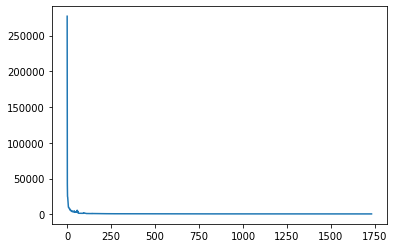

In [13]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])




### some diagnosis

In [14]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
z

<tf.Tensor: shape=(64, 64), dtype=float32, numpy=
array([[ 1260.8485 , -1277.6693 ,   362.5398 , ...,  1326.1696 ,
         1564.7059 , -1499.6053 ],
       [ -437.6482 , -1170.1024 ,  1703.1157 , ..., -1301.2518 ,
         2247.353  ,   526.0226 ],
       [  775.1194 ,   191.4211 ,   457.7822 , ...,   212.22072,
         1785.094  , -1469.0306 ],
       ...,
       [   65.46572, -1381.674  ,  -523.21204, ...,  -149.87349,
         3469.7654 ,   -84.23958],
       [   62.76211, -8023.1807 , -2848.1985 , ...,   555.45996,
         -382.25006, -7276.993  ],
       [ -557.2652 ,   711.33295,  -333.89212, ...,  -237.96725,
          375.9903 , -1100.7344 ]], dtype=float32)>

In [15]:
print(autoencoder.decoder(z))
print(e)

tf.Tensor(
[[  13.016111   -20.470198     4.599848  ...    5.2731304  -29.016697
    27.28957  ]
 [  -1.4048508  -24.738474     4.489771  ...   44.01959     83.34568
    53.47057  ]
 [  -2.9664934  -10.372885     7.3289127 ...   41.33692    -36.9049
    92.28079  ]
 ...
 [  16.539345   674.59686     10.672747  ...   -5.3659782 -112.466965
    53.604336 ]
 [   9.56838    114.06248      6.95393   ...   -5.7296543 -106.07869
    13.177456 ]
 [  17.700417    37.345123     7.2038593 ...  233.16978    337.12943
   254.17813  ]], shape=(64, 14883), dtype=float32)
tf.Tensor(
[[   6.55631   28.0786     6.12944 ...   21.601     14.5302    43.2891 ]
 [   2.6901    34.8483     6.14613 ...   28.7308    33.4212    42.899  ]
 [   2.80586   31.6444     7.78342 ...   37.2859    22.7498    95.4406 ]
 ...
 [   9.43948 1085.74      11.3318  ...   68.5695    75.1809   106.025  ]
 [   2.34667   42.9676     4.63837 ...   10.1002     9.85647   22.114  ]
 [  14.3121    32.5128     7.6616  ...  262.931    465.4

In [16]:
autoencoder.encoder.save('../workfiles/simple_ae')


INFO:tensorflow:Assets written to: ../workfiles/simple_ae/assets


In [17]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

44/44 [==============================] - 1s 14ms/step


In [18]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [19]:
df.to_csv("../workfiles/processed_data.csv", index=False)
